In [22]:
import joblib 
import numpy as np 
from matplotlib import pyplot as plt 
from uncertainties import ufloat, unumpy

from pathlib import Path
from tqdm import tqdm
from numpy import array
from core.utils import *
import atlas_mpl_style as ampl
ampl.use_atlas_style(usetex=False)


pkl_path = '/global/cfs/projectdirs/atlas/wys/HEP_Repo/QG_Calibration/NewWorkflow/note_plots'
pkl_path = Path(pkl_path)
nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'Extraction_Results'


nominal_SFs = joblib.load(nominal_path / "none_Extraction_Results.pkl") 

label_pt_bin=[500,600,800,1000,1200,1500,2000]

bin_centers = 0.5 * (np.array(label_pt_bin[:-1]) + np.array(label_pt_bin[1:]))

In [23]:
nominal_SFs['jet_nTracks'][500]['p_Quark']

array([0.0+/-0, 0.0+/-0, 0.0012592558735659018+/-1.0815094524812982e-05,
       0.003516229877759722+/-1.819495085831079e-05,
       0.008113378068709353+/-2.7721812368339523e-05,
       0.015666248168006113+/-3.850848364298517e-05,
       0.02596232421067722+/-4.94918865417252e-05,
       0.03776805406548431+/-5.9612721200700544e-05,
       0.049469474033363596+/-6.820881119571696e-05,
       0.05915497541618699+/-7.461434796068747e-05,
       0.06604434161277188+/-7.878123712947181e-05,
       0.06924979329227718+/-8.048627382205948e-05,
       0.06940413541978653+/-8.048406796752115e-05,
       0.06744965851763671+/-7.929987392999378e-05,
       0.06351294765825044+/-7.686611206937345e-05,
       0.058844405951151015+/-7.395213498871243e-05,
       0.05369841072941142+/-7.068385710580284e-05,
       0.0484137607835778+/-6.707291048574463e-05,
       0.04319151120745935+/-6.336024442923833e-05,
       0.03826593061365204+/-5.9615506581069876e-05,
       0.033650200721719856+/-5.59692

In [24]:
def safe_array_divide_unumpy(numerator, denominator):
    if 0 in unumpy.nominal_values(denominator):
        _denominator_nominal_values = unumpy.nominal_values(denominator)
        _denominator_std_devs = unumpy.std_devs(denominator)
        zero_idx = np.where(_denominator_nominal_values==0)[0]
        _denominator_nominal_values[zero_idx] = np.inf
        _denominator_std_devs[zero_idx] = 0 
        _denominator = unumpy.uarray(_denominator_nominal_values, _denominator_std_devs)

        ratio = np.true_divide(numerator, _denominator) 
        # raise Warning(f"0 exists in the denominator for unumpy, check it!")
    else:
        ratio = np.true_divide(numerator, denominator)        
    return ratio

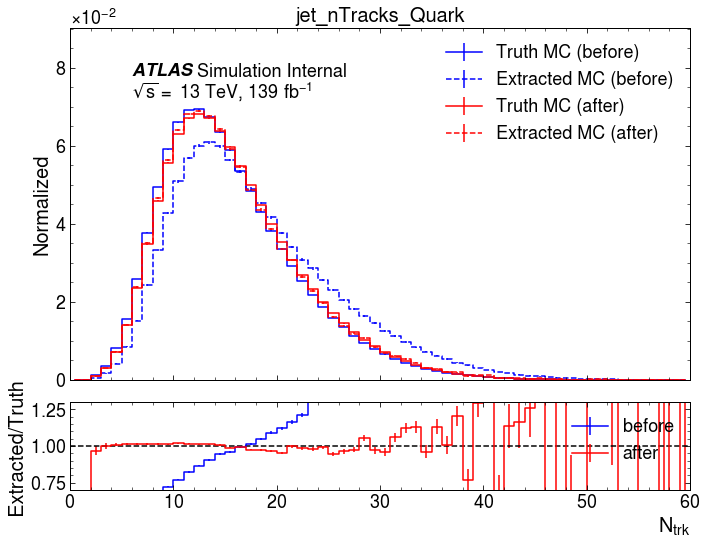

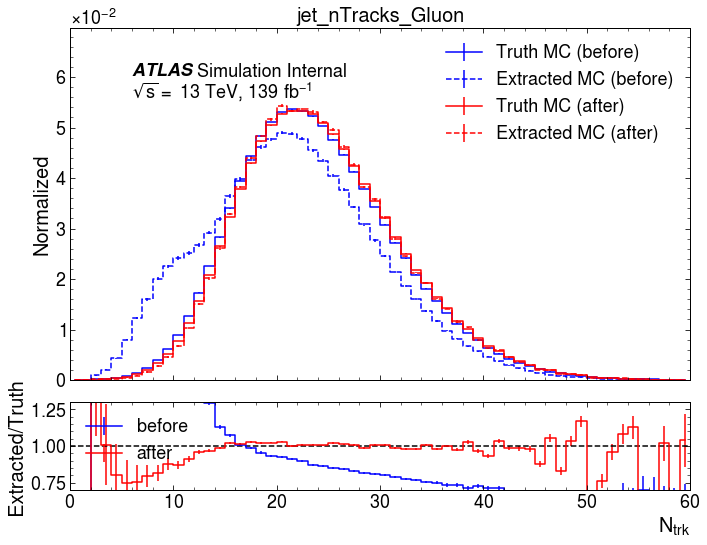

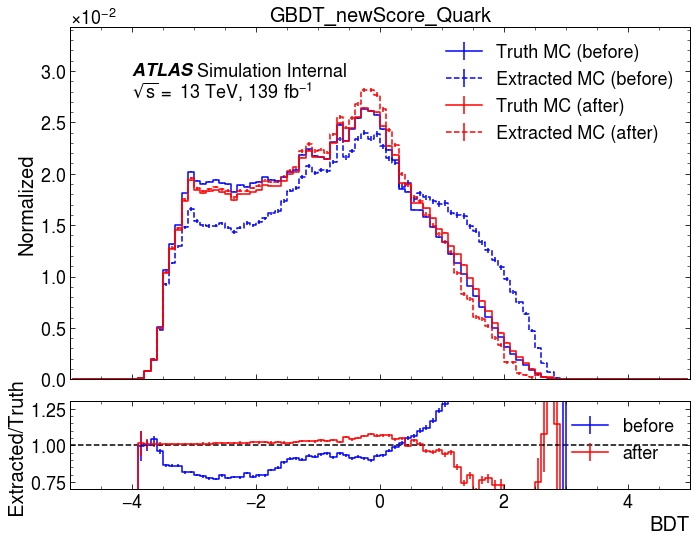

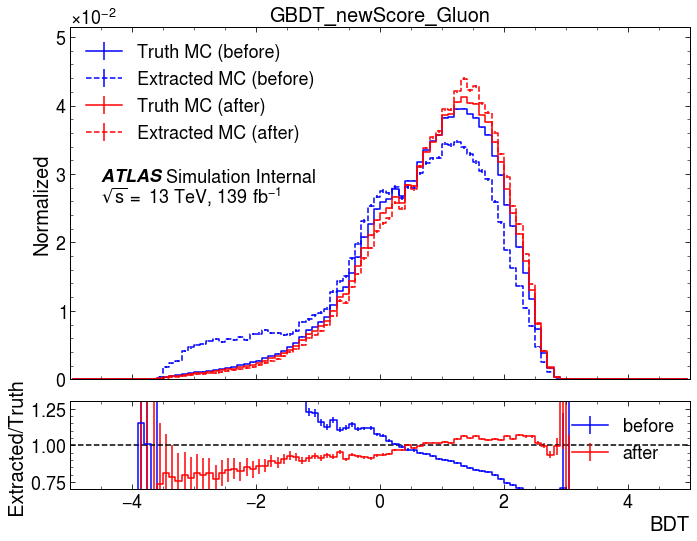

In [30]:
HistBins={
   "jet_nTracks": np.linspace(0, 60, 61),
   'GBDT_newScore' : np.linspace(-5.0, 5.0, 101),
}

Map_var_title = {
    "jet_pt": "$p_{T}$",
    "jet_nTracks": "$N_{trk}$",
    "jet_trackBDT": "old BDT",
    "jet_eta": "$\eta$",
    "jet_trackC1": "$C_{1}$",
    "jet_trackWidth": "W",
    "GBDT_newScore": "BDT"
}



for pt in [500]:#label_pt_bin:
    for rew in ['jet_nTracks','GBDT_newScore']:
        bin_edges = HistBins[rew]
        bin_centers1 = 1/2 * (bin_edges[:-1] + bin_edges[1:])
        ntrk = joblib.load(nominal_path / f"{rew}_Extraction_Results.pkl")

        for parton in ['Quark','Gluon']:

            fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0.1})
            nom_truth = nominal_SFs[rew][pt][f'p_{parton}']
            ntrk_truth = ntrk[rew][pt][f'p_{parton}']        

            nom_Q = nominal_SFs[rew][pt][f'extract_p_{parton}_MC']
            ntrk_Q = ntrk[rew][pt][f'extract_p_{parton}_MC']


            ax0.errorbar(x = bin_centers1, y =unumpy.nominal_values(nom_truth), yerr =unumpy.std_devs(nom_truth),drawstyle = 'steps-mid',label = "Truth MC (before)",color="blue")
            ax0.errorbar(x = bin_centers1, y =unumpy.nominal_values(nom_Q), yerr =unumpy.std_devs(nom_Q),drawstyle = 'steps-mid',label = "Extracted MC (before)",color="blue",linestyle = '--')

            ax0.errorbar(x = bin_centers1, y =unumpy.nominal_values(ntrk_truth), yerr =unumpy.std_devs(ntrk_truth),drawstyle = 'steps-mid',label = "Truth MC (after)",color="red")
            ax0.errorbar(x = bin_centers1, y =unumpy.nominal_values(ntrk_Q), yerr =unumpy.std_devs(ntrk_Q),drawstyle = 'steps-mid',label = "Extracted MC (after)",color="red",linestyle = '--')

            y_max = np.max(unumpy.nominal_values(nom_truth))
            ax0.set_ylim(0, y_max * 1.3)
            ax0.set_ylabel("Normalized")
            ax0.set_title(f"{rew}_{parton}")
            ax0.legend()
            if rew =='GBDT_newScore' and parton == 'Gluon':
                ampl.plot.draw_atlas_label(0.05, 0.6, ax=ax0, energy="13 TeV",lumi=139,simulation=True) 
            else:
                ampl.plot.draw_atlas_label(0.1, 0.9, ax=ax0, energy="13 TeV",lumi=139,simulation=True)

            ratio_truthMC_over_extractedMC = safe_array_divide_unumpy(nom_Q,nom_truth)
            ax1.errorbar(x = bin_centers1,y = unumpy.nominal_values(ratio_truthMC_over_extractedMC), yerr = unumpy.std_devs(ratio_truthMC_over_extractedMC), drawstyle = 'steps-mid',label="before",color="blue")

            ratio_truthMC_over_extractedMC2 = safe_array_divide_unumpy(ntrk_Q,ntrk_truth)
            ax1.errorbar(x = bin_centers1,y = unumpy.nominal_values(ratio_truthMC_over_extractedMC2), yerr = unumpy.std_devs(ratio_truthMC_over_extractedMC2), drawstyle = 'steps-mid',label="after",color="red")

            ax1.set_ylim(0.7,1.3)
            ax1.legend()
            ax1.set_ylabel("Extracted/Truth")
            ax1.set_xlim(bin_edges[0], bin_edges[-1])
            ampl.plot.set_xlabel(f"{Map_var_title[rew]}")
            ax1.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--')




            fig.savefig(f'./mcclosure/mcclosure_{rew}_{parton}_{pt}.pdf')




